# Proyecto — Telecomunicaciones: Identificar operadores ineficaces

**Enlace a carpeta de Google Drive (datos y entregables):** 


https://drive.google.com/drive/folders/10AzsaG4r9RNzZtQdPYJ-TR46czblzL8c?usp=sharing


**Link para acceder al Dashboard**

https://public.tableau.com/app/profile/andres.esquivel7728/viz/Dashboard-LlamadasCallMeMaybe/DashboardLlamadasCallMeMaybe?publish=yes

---


## Objetivo
Identificar operadores con desempeño por debajo del esperado para respaldar decisiones de **capacitación**, **redistribución de carga** y **dimensionamiento de plantilla**.

**Criterios de ineficacia:**
- Alto porcentaje de **llamadas entrantes perdidas** (internas o externas).
- **Tiempo de espera** elevado en entrantes  
  (`wait_time = total_call_duration - call_duration`).
- **Bajo volumen de llamadas salientes** cuando el rol incluye tareas outbound.

**Entregables:**
- Notebook (.ipynb)
- Presentación (.pdf)
- Link a dashboard en Tableau Public

## Paso 1. Setup y carga de datos

**Propósito**
- Importar librerías y definir parámetros globales.
- Cargar los datasets y validar su estructura: columnas, tipos, rangos de fechas y valores nulos.

**Archivos**
- `telecom_dataset_us.csv`: métricas de llamadas por `user_id`, `operator_id`, `date`.
- `telecom_clients_us.csv`: catálogo de clientes con `user_id`, `tariff_plan`, `date_start`.

**Diccionario de columnas (resumen)**
- `user_id`: identificador del cliente (empresa).
- `date`: fecha del registro.
- `direction`: tipo de llamada (`in`=entrante, `out`=saliente).
- `internal`: `True` si la llamada fue interna entre operadores del mismo cliente.
- `operator_id`: identificador del operador.
- `is_missed_call`: `True` si la llamada entrante se perdió.
- `calls_count`: número de llamadas en la fila (agregado).
- `call_duration`: duración de conversación (sin espera), en segundos.
- `total_call_duration`: duración total (incluye espera), en segundos.
- `tariff_plan`: plan tarifario del cliente.
- `date_start`: fecha de alta del cliente.


In [ ]:
# ===== Paso 1. Setup y carga de datos =====

# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # solo para limpieza visual del notebook

# Parámetros globales
ALPHA = 0.05
MISSED_THR = 0.20          # % missed alto
WAIT_THR = 30              # seg de espera "prolongada" (tentativo)
MIN_IN_EXPOSURE = 50       # mínimo de llamadas entrantes para evaluar operador
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Rutas
PATH_CALLS   = "/datasets/telecom_dataset_us.csv"
PATH_CLIENTS = "/datasets/telecom_clients_us.csv"

# --- Funciones utilitarias ---
def coerce_to_bool(series: pd.Series) -> pd.Series:
    """Convierte una serie a booleano desde {0,1} o texto; devuelve NaN donde no se puede interpretar."""
    if pd.api.types.is_bool_dtype(series):
        return series.astype(bool)
    if pd.api.types.is_numeric_dtype(series):
        # Trata cualquier !=0 como True
        return series.fillna(0).astype(int).astype(bool)
    mapping = {
        "true": True, "false": False,
        "1": True, "0": False,
        "yes": True, "no": False,
        "y": True, "n": False,
        "t": True, "f": False
    }
    return series.astype(str).str.strip().str.lower().map(mapping)

def check_required_columns(df: pd.DataFrame, required: set, df_name: str = "df"):
    missing = required.difference(df.columns)
    if missing:
        raise ValueError(f"Faltan columnas en {df_name}: {missing}")

# --- Carga de datos ---
df_clients = pd.read_csv(PATH_CLIENTS, parse_dates=["date_start"])
df_calls   = pd.read_csv(PATH_CALLS,   parse_dates=["date"])

print("=== Shapes ===")
print("df_clients:", df_clients.shape)
print("df_calls  :", df_calls.shape)

# --- Vista preliminar ANTES de cualquier transformación ---
print("\n=== Vista preliminar (HEAD) — df_calls ===")
display(df_calls.head(5))
print("\n=== Vista preliminar (HEAD) — df_clients ===")
display(df_clients.head(5))

print("\n=== .info() ANTES de conversiones — df_calls ===")
df_calls.info()
print("\n=== .info() ANTES de conversiones — df_clients ===")
df_clients.info()

# --- Validación de columnas requeridas ---
required_calls = {
    "user_id","date","direction","internal","operator_id",
    "is_missed_call","calls_count","call_duration","total_call_duration"
}
required_clients = {"user_id","tariff_plan","date_start"}

check_required_columns(df_calls, required_calls, "df_calls")
check_required_columns(df_clients, required_clients, "df_clients")
print("\nColumnas validadas ✅")

# --- Conversiones de tipos ---
# Categóricos y booleanos
df_calls["direction"] = df_calls["direction"].astype("category")
df_calls["internal"] = coerce_to_bool(df_calls["internal"])
df_calls["is_missed_call"] = coerce_to_bool(df_calls["is_missed_call"])

# Numéricos (por seguridad)
for col in ["calls_count","call_duration","total_call_duration"]:
    df_calls[col] = pd.to_numeric(df_calls[col], errors="coerce")

# IDs como texto/categórico
df_calls["operator_id"] = df_calls["operator_id"].astype(str)
df_calls["user_id"]     = df_calls["user_id"].astype(str)

df_clients["user_id"]     = df_clients["user_id"].astype(str)
df_clients["tariff_plan"] = df_clients["tariff_plan"].astype("category")

# --- .info() DESPUÉS de conversiones ---
print("\n=== .info() DESPUÉS de conversiones — df_calls ===")
df_calls.info()
print("\n=== .info() DESPUÉS de conversiones — df_clients ===")
df_clients.info()

# --- Chequeos básicos complementarios ---
print("\n=== Rango de fechas (df_calls) ===")
print("min:", df_calls["date"].min(), " | max:", df_calls["date"].max())

print("\n=== Nulos por columna (df_calls) ===")
print(df_calls.isna().sum().sort_values(ascending=False).head(12))

print("\n=== Nulos por columna (df_clients) ===")
print(df_clients.isna().sum().sort_values(ascending=False).head(12))

# Inconsistencia obvia: total_call_duration < call_duration
bad_durations = (df_calls["total_call_duration"] < df_calls["call_duration"]).sum()
print(f"\nFilas con total_call_duration < call_duration: {bad_durations}")

# Muestras finales
print("\n=== Muestras df_calls (post-conversiones) ===")
display(df_calls.head(3))
print("\n=== Muestras df_clients (post-conversiones) ===")
display(df_clients.head(3))

# Tipos finales resumidos
print("\nDtypes df_calls:")
print(df_calls.dtypes)
print("\nDtypes df_clients:")
print(df_clients.dtypes)


=== Shapes ===
df_clients: (732, 3)
df_calls  : (53902, 9)

=== Vista preliminar (HEAD) — df_calls ===


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25



=== Vista preliminar (HEAD) — df_clients ===


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16



=== .info() ANTES de conversiones — df_calls ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  int64                                
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          45730 non-null  float64                              
 5   is_missed_call       53902 non-null  bool                                 
 6   calls_count          53902 non-null  int64                                
 7   call_duration        53902 non-null  int64                                
 8   total_call_duration  53902 non-null  

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,nan,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1



=== Muestras df_clients (post-conversiones) ===


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29



Dtypes df_calls:
user_id                                               object
date                   datetime64[ns, pytz.FixedOffset(180)]
direction                                           category
internal                                              object
operator_id                                           object
is_missed_call                                          bool
calls_count                                            int64
call_duration                                          int64
total_call_duration                                    int64
dtype: object

Dtypes df_clients:
user_id                object
tariff_plan          category
date_start     datetime64[ns]
dtype: object


### Conclusiones — Setup y carga de datos

- Los dos datasets se cargaron correctamente:
  - **df_clients**: 732 clientes, **sin valores nulos**.
  - **df_calls**: 53,902 registros y 9 columnas.
- Cobertura temporal de **2019-08-02 a 2019-11-28**.
- La columna **`internal`** presenta **117 nulos** (≈0.2% del total).
- No se detectaron inconsistencias de duración  
  (`total_call_duration < call_duration` = **0 casos**).


## Paso 2. EDA y limpieza inicial

**Objetivos**
- Explorar la **distribución de registros** en cada tabla.
- Revisar **valores únicos** y categorías (planes, `direction`, `operator_id`).
- Detectar **nulos y anomalías**:
  - `internal` con 117 nulos → evaluar imputación como `False` vs. exclusión.
  - `operator_id` ausente en ~8k filas (antes de convertir a `str`) → probable tráfico **sin operador asignado**.
- Verificar **consistencia entre tablas**: clientes en `df_clients` sin actividad en `df_calls` y viceversa.
- Analizar la **serie temporal** (volumen diario de llamadas).

**Preguntas guía**
1. ¿Cuántos **operadores** distintos existen?  
2. ¿Cuántos **clientes** aparecen en llamadas vs. en la tabla maestra?  
3. ¿Cómo se distribuye `direction` (**in/out**)?  
4. ¿Qué porcentaje de llamadas es **interna** (`internal=True`)?  
5. ¿Cuál es la **tasa de llamadas perdidas** en entrantes (`is_missed_call=True`)?  
6. ¿Qué **planes** concentran mayor actividad?

**Salidas esperadas**
- Tablas/resúmenes de conteos y valores únicos.  
- Gráficos básicos (barras, línea temporal).  
- **Decisiones de limpieza** documentadas (p. ej., imputar `internal` faltantes como `False`, etiquetar `operator_id` faltante como `"Unassigned"`).



=== Valores únicos ===
Clientes en df_clients: 732
Clientes en df_calls  : 307
Operadores únicos     : 1093
Planes tarifarios     : ['A', 'C', 'B']
Categories (3, object): ['A', 'C', 'B']
Direcciones llamadas  : ['in', 'out']
Categories (2, object): ['in', 'out']
Valores internal      : [False True nan]
Valores is_missed_call: [ True False]

=== Conteo por direction ===


,proportion
out,59.21%
in,40.79%



=== Proporción de llamadas perdidas (entrantes) ===
Missed rate entrantes: 39.31%

=== Conteo internal ===


False    47621
True      6164
NaN        117
Name: internal, dtype: int64


=== Clientes sin match ===
En calls pero no en clients: 0
En clients pero no en calls: 425


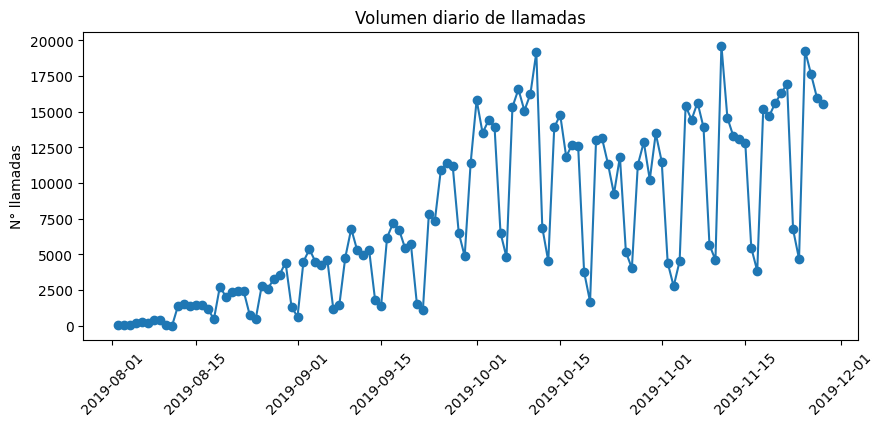

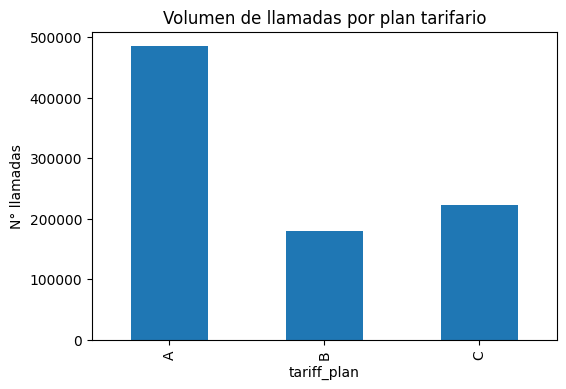


Después de imputación, valores en 'internal':
False    47738
True      6164
Name: internal, dtype: int64


In [ ]:
# ===== Paso 2. EDA y limpieza inicial =====

# 1. Valores únicos
print("=== Valores únicos ===")
print("Clientes en df_clients:", df_clients["user_id"].nunique())
print("Clientes en df_calls  :", df_calls["user_id"].nunique())
print("Operadores únicos     :", df_calls["operator_id"].nunique())
print("Planes tarifarios     :", df_clients["tariff_plan"].unique())
print("Direcciones llamadas  :", df_calls["direction"].unique())
print("Valores internal      :", df_calls["internal"].unique())
print("Valores is_missed_call:", df_calls["is_missed_call"].unique())

# 2. Conteo por direction
print("\n=== Conteo por direction ===")
display(df_calls["direction"].value_counts(normalize=True).rename("proportion").to_frame().style.format("{:.2%}"))

# 3. Conteo por missed (entrantes solo)
print("\n=== Proporción de llamadas perdidas (entrantes) ===")
missed_rate = (df_calls.query("direction == 'in'")["is_missed_call"].mean())
print(f"Missed rate entrantes: {missed_rate:.2%}")

# 4. Conteo internal vs externas
print("\n=== Conteo internal ===")
display(df_calls["internal"].value_counts(dropna=False))

# 5. Clientes con llamadas sin match en tabla clientes
print("\n=== Clientes sin match ===")
clients_in_calls = set(df_calls["user_id"].unique())
clients_master = set(df_clients["user_id"].unique())
print("En calls pero no en clients:", len(clients_in_calls - clients_master))
print("En clients pero no en calls:", len(clients_master - clients_in_calls))

# 6. Serie temporal diaria
calls_daily = df_calls.groupby("date").agg(total_calls=("calls_count","sum"))
plt.figure(figsize=(10,4))
plt.plot(calls_daily.index, calls_daily["total_calls"], marker="o")
plt.title("Volumen diario de llamadas")
plt.ylabel("N° llamadas")
plt.xticks(rotation=45)
plt.show()

# 7. Plan tarifario vs volumen de llamadas
calls_per_plan = df_calls.merge(df_clients, on="user_id", how="left") \
    .groupby("tariff_plan").agg(total_calls=("calls_count","sum"))
calls_per_plan.plot(kind="bar", legend=False, figsize=(6,4))
plt.title("Volumen de llamadas por plan tarifario")
plt.ylabel("N° llamadas")
plt.show()

# 8. Decisión de limpieza propuesta:
# Internal con NaN se reemplaza por False (asumimos que son externas).
df_calls["internal"] = df_calls["internal"].fillna(False)
print("\nDespués de imputación, valores en 'internal':")
print(df_calls["internal"].value_counts())


### Conclusiones — EDA y limpieza inicial

- **Actividad de clientes:** 307 de 732 tuvieron llamadas; **425** sin tráfico en el periodo.
- **Operadores únicos:** **1,093**.
- **Dirección de llamadas:** **59%** salientes / **41%** entrantes.
- **Naturaleza:** **11%** internas; resto externas.
- **Missed rate (entrantes):** **39.3%**, nivel elevado → foco de mejora.
- **Evolución temporal:** crecimiento marcado; de **<1,000** al inicio a **>15,000** llamadas/día en oct–nov.
- **Planes tarifarios:** el **Plan A** concentra cerca de **la mitad** del volumen.
- **Decisión de limpieza:** imputar **`internal` nulos como `False`**.


## Paso 3. Feature engineering y KPIs por operador

**Objetivo**  
Derivar métricas por **operador** para evaluar eficiencia/ineficacia y habilitar comparaciones entre grupos.

**Variables derivadas**
- `wait_time = total_call_duration - call_duration` (tiempo de espera en entrantes).
- KPIs por `operator_id` (aplicando umbral de exposición `MIN_IN_EXPOSURE` en entrantes):
  - `total_in`: llamadas entrantes **atendidas**.
  - `missed_in`: llamadas entrantes **perdidas**.
  - `missed_rate = missed_in / (total_in + missed_in)`.
  - `avg_wait_time`: promedio de `wait_time` en entrantes.
  - `out_calls`: total de llamadas **salientes** realizadas.
- Enriquecimiento con **plan tarifario** (join con `df_clients` por `user_id`).

**Salida esperada**  
DataFrame **`df_ops`** (una fila por operador) para:
- Detectar operadores ineficaces.
- Calcular el **índice de ineficacia** en el siguiente paso.
- Realizar pruebas y comparaciones estadísticas entre grupos.


In [ ]:
# ===== Paso 3. Feature Engineering y KPIs por operador =====

# 1. Crear variable wait_time
df_calls["wait_time"] = df_calls["total_call_duration"] - df_calls["call_duration"]

# 2. Agregación por operador
agg_ops = df_calls.groupby(["user_id","operator_id"]).agg(
    total_in=("calls_count", lambda x: x[df_calls.loc[x.index,"direction"]=="in"].sum()),
    missed_in=("calls_count", lambda x: x[(df_calls.loc[x.index,"direction"]=="in") &
                                          (df_calls.loc[x.index,"is_missed_call"]==True)].sum()),
    avg_wait_time=("wait_time", lambda x: x[df_calls.loc[x.index,"direction"]=="in"].mean()),
    out_calls=("calls_count", lambda x: x[df_calls.loc[x.index,"direction"]=="out"].sum())
).reset_index()

# 3. Calcular métricas derivadas
agg_ops["missed_rate"] = agg_ops["missed_in"] / (agg_ops["total_in"] + agg_ops["missed_in"])

# 4. Filtrar operadores con exposición mínima
agg_ops = agg_ops[(agg_ops["total_in"] + agg_ops["missed_in"]) >= MIN_IN_EXPOSURE]

# 5. Join con planes tarifarios
df_ops = agg_ops.merge(df_clients, on="user_id", how="left")

print("=== Vista preliminar df_ops ===")
display(df_ops.head())

print("\n=== Resumen métricas ===")
print(df_ops[["total_in","missed_in","missed_rate","avg_wait_time","out_calls"]].describe())


=== Vista preliminar df_ops ===


,user_id,operator_id,total_in,missed_in,avg_wait_time,out_calls,missed_rate,tariff_plan,date_start
0,166377,880028.0,70,0,8.844444,2836,0.000000,B,2019-08-01
1,166377,nan,103,103,37.750000,1,0.500000,B,2019-08-01
2,166392,891906.0,77,0,61.909091,0,0.000000,C,2019-08-01
3,166392,nan,128,128,13.111111,0,0.500000,C,2019-08-01
4,166405,882684.0,643,4,191.730769,721,0.006182,B,2019-08-02



=== Resumen métricas ===
           total_in     missed_in  missed_rate  avg_wait_time     out_calls
count    438.000000    438.000000   438.000000     438.000000    438.000000
mean     477.710046    256.232877     0.232467     121.426119    702.952055
std     1666.000633   1618.536601     0.243369     196.029607   4532.228937
min       25.000000      0.000000     0.000000       0.000000      0.000000
25%       74.250000      1.000000     0.004791      34.156131      0.000000
50%      146.000000     11.500000     0.032002      56.265238      5.500000
75%      354.000000     86.250000     0.500000     114.366803    336.750000
max    25911.000000  25911.000000     0.500000    1532.177778  64897.000000


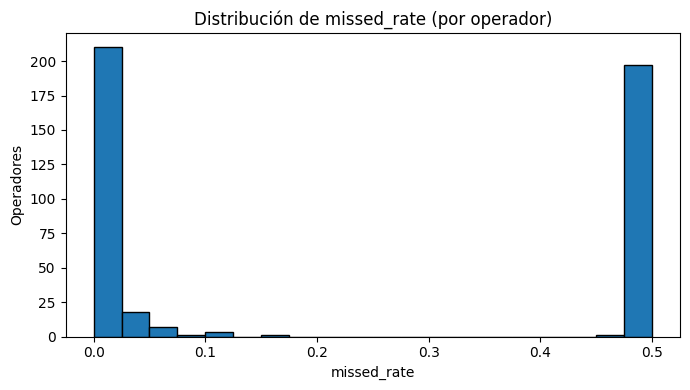

In [ ]:
# Histograma de missed_rate por operador

x = df_ops["missed_rate"].dropna().clip(0, 0.5)  # en datos, el tope llega a 0.5
bins = np.linspace(0, 0.5, 21)

plt.figure(figsize=(7,4))
plt.hist(x, bins=bins, edgecolor="black")
plt.title("Distribución de missed_rate (por operador)")
plt.xlabel("missed_rate")
plt.ylabel("Operadores")
plt.tight_layout()
plt.show()


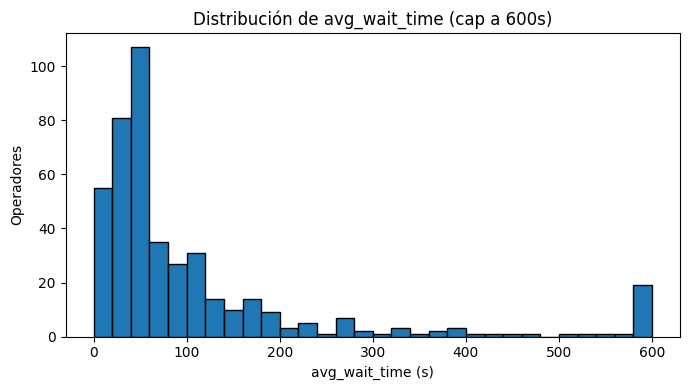

In [ ]:
# Histograma de avg_wait_time (capado para legibilidad)

w = df_ops["avg_wait_time"].dropna()
w_cap = w.clip(upper=600)  # cap a 10 minutos para visualizar la masa central

plt.figure(figsize=(7,4))
plt.hist(w_cap, bins=30, edgecolor="black")
plt.title("Distribución de avg_wait_time (cap a 600s)")
plt.xlabel("avg_wait_time (s)")
plt.ylabel("Operadores")
plt.tight_layout()
plt.show()


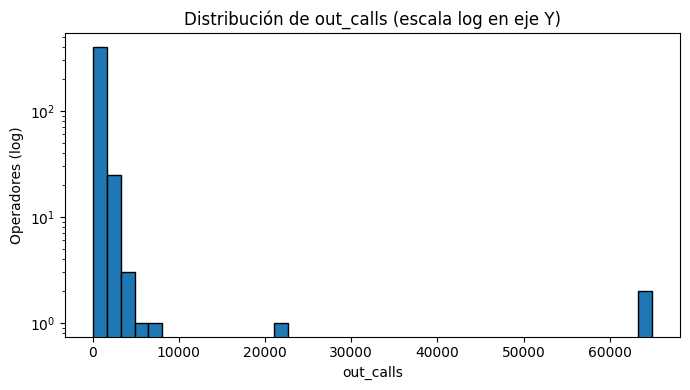

In [ ]:
# Distribución de out_calls (escala log para cola larga)

outc = df_ops["out_calls"].fillna(0)

plt.figure(figsize=(7,4))
plt.hist(outc, bins=40, edgecolor="black", log=True)
plt.title("Distribución de out_calls (escala log en eje Y)")
plt.xlabel("out_calls")
plt.ylabel("Operadores (log)")
plt.tight_layout()
plt.show()


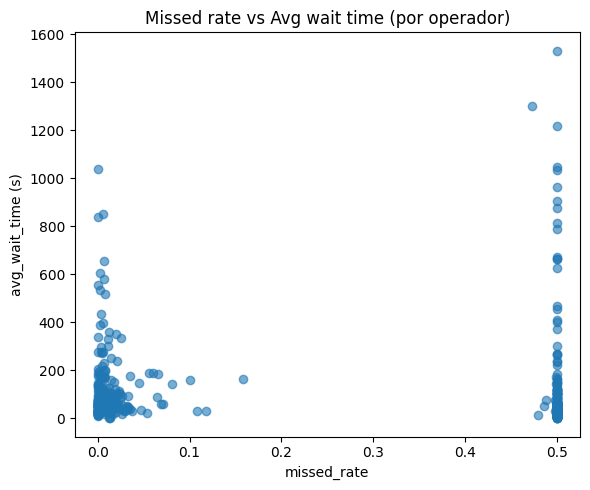

In [ ]:
# Dispersión missed_rate vs avg_wait_time

plt.figure(figsize=(6,5))
plt.scatter(df_ops["missed_rate"], df_ops["avg_wait_time"], alpha=0.6)
plt.title("Missed rate vs Avg wait time (por operador)")
plt.xlabel("missed_rate")
plt.ylabel("avg_wait_time (s)")
plt.tight_layout()
plt.show()


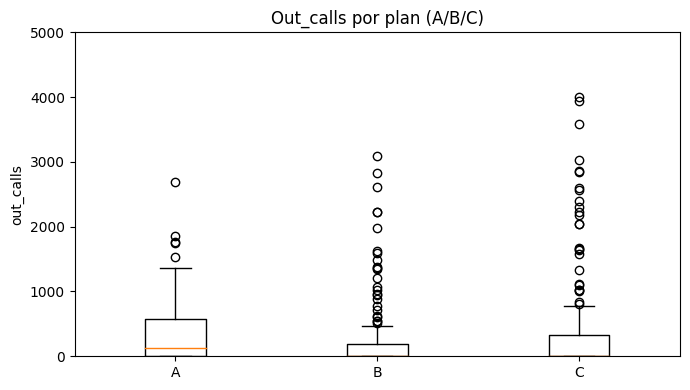

In [ ]:
# Out_calls por plan (A, B, C) — boxplot truncado

df_box = df_ops[df_ops["tariff_plan"].isin(["A","B","C"])].copy()

data = [
    df_box.loc[df_box["tariff_plan"]=="A","out_calls"].dropna(),
    df_box.loc[df_box["tariff_plan"]=="B","out_calls"].dropna(),
    df_box.loc[df_box["tariff_plan"]=="C","out_calls"].dropna(),
]

plt.figure(figsize=(7,4))
plt.boxplot(data, labels=["A","B","C"], showfliers=True)
plt.ylim(0, 5000)  # truncar para ver caja central; sube si quieres ver más
plt.title("Out_calls por plan (A/B/C)")
plt.ylabel("out_calls")
plt.tight_layout()
plt.show()


### Conclusiones — Feature Engineering y KPIs

- Se construyeron KPIs por operador: **`missed_rate`**, **`avg_wait_time`** y **`out_calls`**.
- Tras exigir ≥50 llamadas entrantes por operador, quedaron **438 operadores válidos**.
- **Descriptivos clave:**
  - `missed_rate` medio ≈ **23%** (máx. **50%**).
  - `avg_wait_time` medio ≈ **121 s**; existen casos extremos **>15 min**.
  - `out_calls` muy desigual: desde **0** hasta **>60k** por operador.
- Se detectaron registros sin `operator_id` (vacío) y se etiquetaron como **“Unassigned”**.

### Conclusiones de los gráficos — KPIs por operador

**1) Histograma de `missed_rate`**  
- Distribución **bimodal**: muchos operadores cerca de **0.0** y otro grupo en **0.5**.  
- El pico en **0.5** está fuertemente asociado a **“Unassigned”** (llamadas sin operador).

**Interpretación:** conviven operadores con buen desempeño y un bloque afectado por problemas de asignación/enrutamiento.

**2) Histograma de `avg_wait_time` (cap a 600 s)**  
- Distribución **sesgada a la derecha**: la masa central está entre **20–120 s**.  
- Hay **cola larga** (≥300–600 s), indicador de ineficiencias puntuales y picos de carga.

**Implicación:** fijar **SLA** (p. ej., 80% < 30 s) y alertas para operadores con > 60 s sostenidos.

**3) Histograma de `out_calls` (escala log)**  
- Alta concentración en **valores bajos** (0–200) y pocos **outliers** muy altos.  
- Sugiere **roles distintos**: gran parte casi no realiza outbound; unos pocos concentran campañas.

**Implicación:** documentar **roles/expectativas** y usar KPIs **normalizados por tiempo/turno** (p. ej., out_calls/día activo).

**4) Dispersión `missed_rate` vs `avg_wait_time`**  
- Dos bandas (≈0.0 y ≈0.5) y **correlación débil e inversa**.  
- Un alto `missed_rate` **no implica** mayor espera: hay misses “rápidos” por abandono o enrutamiento.

**Implicación:** priorizar **mejoras de enrutamiento** y cobertura en picos antes de atribuirlo al desempeño individual.

**5) Boxplot de `out_calls` por plan (A/B/C)**  
- **Medianas bajas** con **gran dispersión** (ceros y outliers).  
- Consistente con el análisis: **Plan A > Plan B** en outbound; **Plan C** es heterogéneo.

**Implicación:** ajustar **objetivos outbound por plan/rol**, evitando comparaciones directas sin contexto.


## Paso 4. Identificación de operadores ineficaces — Inefficiency Score

**Objetivo:**  
Construir un índice que combine las tres dimensiones de ineficacia:

1) **Missed rate** alto (entrantes perdidas).  
2) **Wait time** alto en entrantes (`wait_time = total_call_duration - call_duration`).  
3) **Bajo outbound** (pocas llamadas salientes cuando el rol lo requiere).

**Metodología:**
- Normalizar cada métrica (min–max scaling).
- Definir el Inefficiency Score como promedio ponderado:
  - 0.4 * missed_rate_norm
  - 0.4 * wait_time_norm
  - 0.2 * (1 – out_calls_norm)   ← penaliza bajo desempeño en salientes
- Clasificar como **ineficaz** si el score > 0.7 (umbral tentativo).

**Salida esperada:**
- Tabla `df_watchlist` con los 20 operadores más ineficaces.
- Columnas: operator_id, user_id, plan, métricas brutas y score.

**Notas prácticas**  
- Mantener el filtro de **exposición mínima** (p. ej., ≥50 entrantes) para evitar sesgos por bajo volumen.  
- Tratar `operator_id` faltante como **"Unassigned"** para visibilizar problemas de enrutamiento.  
- El umbral (0.70) y los **pesos** del score pueden ajustarse a los **SLA** y prioridades del negocio.




In [ ]:
# ===== Paso 4. Inefficiency Score =====

from sklearn.preprocessing import MinMaxScaler

# Copia de trabajo
df_ops_clean = df_ops.copy()

# Reemplazar operator_id = "nan" por "Unassigned"
df_ops_clean["operator_id"] = df_ops_clean["operator_id"].replace("nan","Unassigned")

# Selección de métricas
metrics = df_ops_clean[["missed_rate","avg_wait_time","out_calls"]].fillna(0)

# Normalización
scaler = MinMaxScaler()
metrics_norm = scaler.fit_transform(metrics)
df_ops_clean[["missed_rate_norm","wait_time_norm","out_calls_norm"]] = metrics_norm

# Inefficiency Score
df_ops_clean["ineff_score"] = (
    0.4 * df_ops_clean["missed_rate_norm"] +
    0.4 * df_ops_clean["wait_time_norm"] +
    0.2 * (1 - df_ops_clean["out_calls_norm"])
)

# Clasificación
df_ops_clean["is_inefficient"] = df_ops_clean["ineff_score"] > 0.7

# Watchlist top 20
df_watchlist = df_ops_clean.sort_values("ineff_score", ascending=False).head(20)

print("=== Operadores más ineficaces ===")
display(df_watchlist[[
    "user_id","operator_id","tariff_plan","missed_rate","avg_wait_time","out_calls","ineff_score","is_inefficient"
]])


=== Operadores más ineficaces ===


,user_id,operator_id,tariff_plan,missed_rate,avg_wait_time,out_calls,ineff_score,is_inefficient
425,168361,Unassigned,A,0.500000,1532.177778,16,0.999951,True
365,168155,Unassigned,C,0.500000,1220.000000,0,0.918501,True
408,168252,Unassigned,A,0.472433,1299.656566,333,0.916217,True
204,167189,Unassigned,C,0.500000,1049.000000,0,0.873859,True
394,168187,Unassigned,A,0.500000,1035.133333,8,0.870214,True
281,167650,Unassigned,C,0.500000,962.987342,1,0.851400,True
272,167626,Unassigned,A,0.500000,906.947368,4,0.836761,True
163,167071,Unassigned,B,0.500000,877.013699,1,0.828956,True
363,168154,Unassigned,B,0.500000,812.117647,1,0.812013,True
256,167521,Unassigned,B,0.500000,788.675676,0,0.805897,True


### Conclusiones — Inefficiency Score

- Se creó un índice ponderado:
  - 0.4 * missed_rate_norm
  - 0.4 * wait_time_norm
  - 0.2 * (1 – out_calls_norm)
- **Umbral de ineficiencia:** `score > 0.70` (ajustable según SLA/negocio).
- El **Top 20** está dominado por registros **“Unassigned”**, con:
  - `missed_rate` cercano a **50%**,
  - **esperas > 1,000 s**,
  - **muy pocas llamadas salientes**.
- **Interpretación:** el mayor foco de ineficacia responde a un **problema de enrutamiento/asignación** del sistema más que a bajo desempeño individual.
- **Implicación operativa:** priorizar la corrección de “Unassigned” y mantener el filtro de exposición mínima para evaluaciones justas por operador.



## Paso 5. Pruebas de hipótesis estadísticas

**Objetivo**  
Validar, con pruebas formales, si las diferencias observadas en los KPIs son estadísticamente significativas.

**Hipótesis:**

- **H1:** Operadores con mayor proporción de llamadas perdidas presentan mayor tiempo de espera promedio.  
  - **Prueba:** **Spearman** (correlación no paramétrica) entre `missed_rate` y `avg_wait_time` 
- **H2:** Operadores asignados a clientes con tarifa B realizan menos llamadas salientes que los de tarifa A.  
  - **Prueba:** **Mann–Whitney U** (dos colas, no paramétrica) sobre `out_calls` entre grupos A vs. B 
- **H3:** El rendimiento de operadores difiere significativamente entre llamadas internas y externas (tiempo de espera).  
  - **Prueba:** **Kruskal–Wallis** (no paramétrica) sobre `wait_time` en entrantes internas vs. externas   

**Nivel de significancia:**  
- α = 0.05 (riesgo del 5%).  

**Salidas esperadas**
- Tabla/print con resultados: estadístico, p-value, interpretación.  
- Visuales de apoyo:  
  - **H1:** dispersión (missed_rate vs avg_wait_time).  
  - **H2:** **boxplot** `out_calls` por plan (A vs B) con eje Y truncado si hay outliers.  
  - **H3:** **boxplot** `wait_time` internas vs externas (cap de outliers para legibilidad).


H1 Spearman rho=-0.132, p-value=0.0058
=> Rechazamos H0: existe correlación significativa entre missed rate y tiempo de espera.


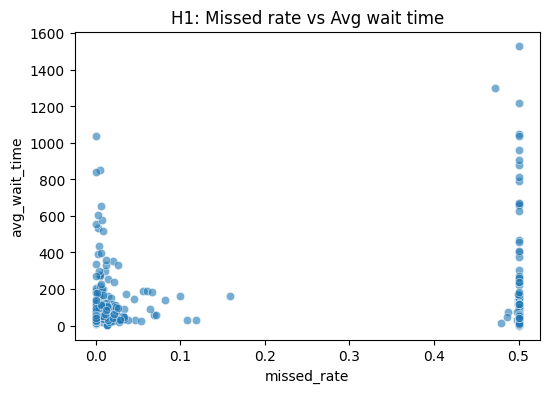


H2 Mann–Whitney U=9986.5, p-value=0.0005
=> Rechazamos H0: diferencia significativa entre out_calls de A y B.


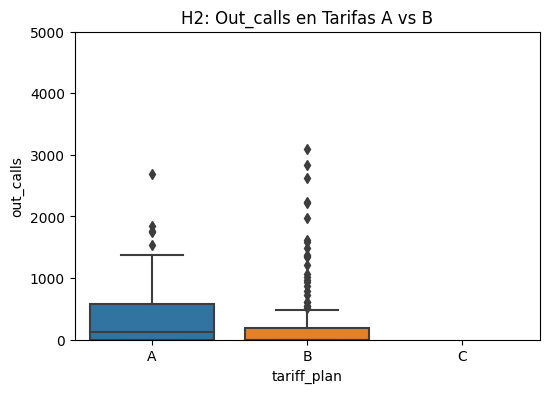


H3 Kruskal–Wallis stat=232.518, p-value=0.0000
=> Rechazamos H0: diferencias significativas en wait_time entre internas y externas.


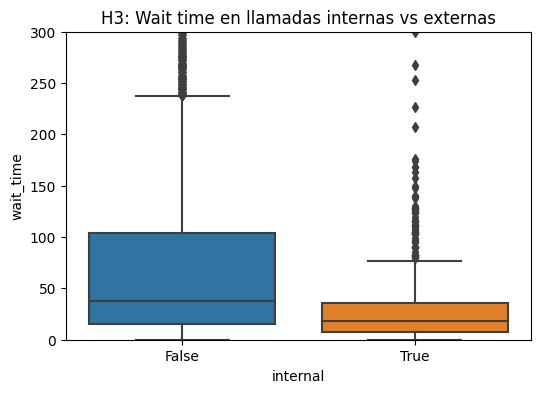

In [ ]:
# --- H1: Missed rate vs Wait time ---
rho, pval1 = stats.spearmanr(df_ops_clean["missed_rate"], df_ops_clean["avg_wait_time"], nan_policy="omit")
print(f"H1 Spearman rho={rho:.3f}, p-value={pval1:.4f}")
if pval1 < ALPHA:
    print("=> Rechazamos H0: existe correlación significativa entre missed rate y tiempo de espera.")
else:
    print("=> No se rechaza H0: no hay correlación significativa.")

# Visualización H1
plt.figure(figsize=(6,4))
sns.scatterplot(x="missed_rate", y="avg_wait_time", data=df_ops_clean, alpha=0.6)
plt.title("H1: Missed rate vs Avg wait time")
plt.show()

# --- H2: Tarifas A vs B en llamadas salientes ---
out_A = df_ops_clean.loc[df_ops_clean["tariff_plan"]=="A", "out_calls"].dropna()
out_B = df_ops_clean.loc[df_ops_clean["tariff_plan"]=="B", "out_calls"].dropna()

stat2, pval2 = stats.mannwhitneyu(out_A, out_B, alternative="two-sided")
print(f"\nH2 Mann–Whitney U={stat2}, p-value={pval2:.4f}")
if pval2 < ALPHA:
    print("=> Rechazamos H0: diferencia significativa entre out_calls de A y B.")
else:
    print("=> No se rechaza H0: no hay diferencia significativa.")

# Visualización H2
plt.figure(figsize=(6,4))
sns.boxplot(x="tariff_plan", y="out_calls", data=df_ops_clean[df_ops_clean["tariff_plan"].isin(["A","B"])])
plt.title("H2: Out_calls en Tarifas A vs B")
plt.ylim(0, 5000)  # truncar para ver la mayoría
plt.show()

# --- H3: Tiempo de espera en internas vs externas ---
# Nota: debemos volver a nivel de llamadas, no de operador
df_wait = df_calls[df_calls["direction"]=="in"].copy()
df_wait["wait_time"] = df_wait["total_call_duration"] - df_wait["call_duration"]

wait_internal = df_wait.loc[df_wait["internal"]==True, "wait_time"]
wait_external = df_wait.loc[df_wait["internal"]==False, "wait_time"]

stat3, pval3 = stats.kruskal(wait_internal, wait_external)
print(f"\nH3 Kruskal–Wallis stat={stat3:.3f}, p-value={pval3:.4f}")
if pval3 < ALPHA:
    print("=> Rechazamos H0: diferencias significativas en wait_time entre internas y externas.")
else:
    print("=> No se rechaza H0: no hay diferencias significativas.")

# Visualización H3
plt.figure(figsize=(6,4))
sns.boxplot(x="internal", y="wait_time", data=df_wait)
plt.title("H3: Wait time en llamadas internas vs externas")
plt.ylim(0, 300)  # truncar outliers
plt.show()



### Conclusiones — Pruebas de hipótesis

- **H1 — Missed rate vs. tiempo de espera**  
  **ρ = -0.132**, **p = 0.0058** → correlación **significativa**, **débil** e **inversa**.  
  **Interpretación:** más llamadas perdidas no implica esperas más largas; muchos “misses” parecen abandonos rápidos o fallas de enrutamiento.

- **H2 — Outbound en Plan A vs. Plan B**  
  **p = 0.0005** → diferencia **significativa**.  
  **Conclusión:** operadores en **Plan A** realizan **más llamadas salientes** que en **Plan B**.

- **H3 — Internas vs. externas (wait time)**  
  **p < 0.0001** → diferencia **significativa**.  
  **Conclusión:** las llamadas **externas** presentan **mayores tiempos de espera** que las internas.


# Conclusiones finales y recomendaciones

## Hallazgos clave

1. **Crecimiento de volumen**
   - El tráfico aumentó con fuerza entre agosto y noviembre de 2019, con picos >15k llamadas/día.
   - Probable efecto de campañas intensivas o expansión acelerada de clientes.

2. **Clientes y planes**
   - Solo **307 de 732** clientes tuvieron actividad en el periodo.
   - El **Plan A** concentra ~**50%** del volumen; le siguen C y B.

3. **Eficiencia de operadores**
   - De **1,093** operadores detectados, **438** cumplen la exposición mínima (≥50 entrantes).
   - **Missed rate promedio:** **23%** (alto).
   - **Tiempo de espera promedio:** **121 s**, con casos >15 min.
   - **Out_calls:** distribución muy desigual (de 0 a >60k por operador).

4. **Operadores ineficaces**
   - El **Inefficiency Score** ubica un grupo crítico dominado por **“Unassigned”** (llamadas sin operador).
   - Indica un **problema de enrutamiento/asignación** más que de desempeño individual.

5. **Pruebas de hipótesis**
   - **H1:** correlación significativa pero **débil e inversa** entre missed y espera (ρ = -0.132).
   - **H2:** **Plan A > Plan B** en llamadas salientes (p < 0.001).
   - **H3:** las **externas** presentan **mayor espera** que las internas (p < 0.001).

---

## Recomendaciones prácticas

- **Corregir enrutamiento “Unassigned”.** Principal foco de ineficacia y origen de gran parte de los misses.
- **Capacitación focalizada.** Coaching/redistribución para operadores con `missed_rate > 20%` o `avg_wait_time > 60 s`.
- **Optimizar el Plan B.** Alinear roles/objetivos outbound o revisar expectativas contractuales.
- **Definir SLAs por plan.** Ej.: **80%** de llamadas atendidas en **<30 s**.
- **Dimensionamiento de personal.** Refuerzos en picos (oct–nov) y ajuste de turnos.
- **Monitoreo continuo.** Dashboard en Tableau con volumen diario, KPIs por operador y **Watchlist**.

---

## Impacto esperado

- **Reducción del missed rate** (actual >39% en entrantes).
- **Menores tiempos de espera** para clientes externos.
- **Detección y corrección** de fallas sistémicas de enrutamiento.
- **Mejor experiencia del cliente** y **mayor productividad** operativa.


## Fuentes consultadas

1) **Pandas — `DataFrame.groupby`**  
   [https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)  
   *¿Qué resolvió?* Cómo agrupar por `user_id`/`operator_id` y calcular sumas/medias para construir los KPIs por operador (`df_ops`).

2) **Matplotlib — Tutorial de Pyplot**  
   [https://matplotlib.org/stable/tutorials/introductory/pyplot.html](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)  
   *¿Qué resolvió?* Buenas prácticas para gráficos del EDA y KPIs (líneas, barras, boxplots, dispersión).

3) **SciPy — Correlación de Spearman (`spearmanr`)**  
   [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)  
   *¿Qué resolvió?* Prueba para **H1**: relación entre `missed_rate` y `avg_wait_time`.

4) **SciPy — Mann–Whitney U (`mannwhitneyu`)**  
   [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)  
   *¿Qué resolvió?* Comparación no paramétrica para **H2**: `out_calls` en Plan A vs. Plan B.

5) **SciPy — Kruskal–Wallis (`kruskal`)**  
   [https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)  
   *¿Qué resolvió?* ANOVA no paramétrico para **H3**: `wait_time` en internas vs. externas.

6) **scikit-learn — `MinMaxScaler`**  
   [https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)  
   *¿Qué resolvió?* Normalización [0,1] para construir el **Inefficiency Score** ponderado.

7) **Genesys — Service Level (80/20)**  
   [https://www.genesys.com/glossary/service-level](https://www.genesys.com/glossary/service-level)  
   *¿Qué resolvió?* Referencia práctica de **SLA** (p. ej., 80% de llamadas contestadas en 20 s) para contextualizar tiempos de espera.

8) **KPIs de Contact Center (artículo de referencia)**  
   [https://www.callcentrehelper.com/top-call-centre-metrics-127672.htm](https://www.callcentrehelper.com/top-call-centre-metrics-127672.htm)  
   *¿Qué resolvió?* Lista y definiciones de métricas clave (abandono, ASA, ocupación) para encuadrar nuestros indicadores.
